# Project Goals
This project aims to enable people seeking a job to get an overview over jobs which have very similar skillset requirements and job descriptions.
This is achieved by taking a dataset of job postings (see below), which include a list of skills, and using that data to calculate the similarity between two job postings, based on their skills and job descriptions.
We will further aim to generate a list of skills for a given job summary, which would enable hiring managers to generate the list of skills for their job postings from the summary they have written.

## Approach
We will start by examining the data and cleaning it up, then we will use a modified bag of words approach to vectorise the job summaries and skills, and calculate the similarity (the distance between their vectorised summary and skills list) between two job postings.
In a second approach, we will use a Random Forest classifier to predict the skill list for a job posting based on its summary. We will train the model on a subset of the data, and then use it to predict the skill list for a different subset of the data. We will then compare the predicted skill list to the actual skill list to see how well the model performs.
We will end with a short summary of interesting findings, and a discussion of potential improvements and further steps.

## Data
Dataset: Asaniczka. (2024). 1.3M Linkedin Jobs & Skills (2024) [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DS/4418374

The dataset contains 1,348,454 job listings (rows), scraped from LinkedIn (publicly available listings on https://www.linkedin.com/jobs/) in January 2024.
The job listings were from 4 countries: the United States, the United Kingdom, Canada, and Australia, with following distributions:
- United States: 1,149,342 - 85%
- United Kingdom: 113,421 - 9%
- Canada: 55,972 - 4%
- Australia: 29,719 - 2%

The dataset provides the following files:
- linkedin_job_postings.csv: the job postings with data and metadata (such as company, job location, job title, search criteria, etc.) - 14 columns total (see below), sans summary and skills - ca. 420 MB
- job_skills.csv: the list of skills for each job link, skills are comma-seperated within one column - ca. 670 MB
- job_summary.csv: the summary of each job link - ca. 5.1 GB

While the job_skills and job_summary files each only contain one relevant column each (next to the link, which acts as the key), the job_postings file is more complex and contains the following columns:
- job_link: the link to the job posting - acts as the primary key in the overall dataset - string
- last_processed_time: the time the job posting was last processed during data collection - datetime
- got_summary: whether the job posting has a summary that was successfully extracted during data collection - boolean
- got_ner: indicates whether Named Entity Recognition (NER) was performed on the job posting or not - boolean
- is_being_worked: whether the job posting is currently being worked on - boolean
- job_title: the title of the job listing - string
- company: the company who created the job listing - string
- job_location: the location of the job (city, state, country (only if not US)) - string
- first_seen: the time the job posting was first seen on LinkedIn - datetime
- search_city: city used as a search criterion for collecting the job posting - string
- search_country: country used as a search criterion for collecting the job postings - string
- search_position: position used as a search criterion for collecting the job postings - string
- job_level: the job level of the job - there seem to be only two of these (see below) - string
- job_type: the type of the job (Onsite, Hybrid, Remote, etc. - see below) - string

All data already has the appropriate data types, so we don't need to convert anything.

In [59]:
import numpy as np  # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

## Loading the data
Let's start by loading our three .csv files and taking a look at the data we have to work with.

In [60]:
# Load the data
job_postings = pd.read_csv('E:/Programming/cu-boulder/machine-learning/Course 1/project/data/linkedin_job_postings.csv')
job_summaries = pd.read_csv('E:/Programming/cu-boulder/machine-learning/Course 1/project/data/job_summary.csv')
job_skills = pd.read_csv('E:/Programming/cu-boulder/machine-learning/Course 1/project/data/job_skills.csv')

In [61]:
# Display the first few rows of the datasets
print("Number of rows for postings: ", job_postings.shape[0])
print(job_postings.head())
print("\n\n\n")
print("Number of rows for summaries: ", job_summaries.shape[0])
print(job_summaries.head())
print("\n\n\n")
print("Number of rows for skills: ", job_skills.shape[0])
print(job_skills.head())

Number of rows for postings:  1348454
                                            job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/group-unit-...   

             last_processed_time got_summary got_ner is_being_worked  \
0   2024-01-21 07:12:29.00256+00           t       t               f   
1   2024-01-21 07:39:58.88137+00           t       t               f   
2  2024-01-21 07:40:00.251126+00           t       t               f   
3  2024-01-21 07:40:00.308133+00           t       t               f   
4  2024-01-19 09:45:09.215838+00           f       f               f   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURA

We don't have skills and/or summaries for some postings, as can be seen by lower row counts (by 52,073 and 51,112 rows respectively) when compared to the number of rows in the job_postings, but that's fine, we'll just ignore those listings when analysing skills/summaries.

## Data Exploration & Cleaning
Let's start by exploring the data and checking for missing values.

In [62]:
print("Job Skills Invalid Values")
print(job_skills.isna().sum())
print("")
print("Job Summaries Invalid Values")
print(job_summaries.isna().sum())
print("")
print("Job Postings Invalid Values")
print(job_postings.isna().sum())

Job Skills Invalid Values
job_link         0
job_skills    2085
dtype: int64

Job Summaries Invalid Values
job_link       0
job_summary    0
dtype: int64

Job Postings Invalid Values
job_link                0
last_processed_time     0
got_summary             0
got_ner                 0
is_being_worked         0
job_title               0
company                11
job_location           19
first_seen              0
search_city             0
search_country          0
search_position         0
job_level               0
job_type                0
dtype: int64


As we can see, most of our data looks quite good.
We will drop the rows with missing values in the job_skills dataset, because they are unuseable for us when they do not include the skills.
We can work with the (very few) missing company and job_location values in the job_postings dataset though, so we'll keep those rows.

In [63]:
# Drop the job_skills rows with missing values
job_skills = job_skills.dropna()

Let's have a look at the different job titles in the job_postings dataset.

In [64]:
unique_titles_lower = job_postings['job_title'].str.lower().unique()
unique_titles = job_postings['job_title'].unique()
print("Unique Job Titles: ", len(unique_titles))
print(job_postings['job_title'].value_counts())

print("______________________________________________________________")
print("Unique Job Titles (lower case): ", len(unique_titles_lower))
print(job_postings['job_title'].str.lower().value_counts())

Unique Job Titles:  584544
job_title
LEAD SALES ASSOCIATE-FT                                                                                    7325
Shift Manager                                                                                              5818
First Year Tax Professional                                                                                5356
Assistant Manager                                                                                          5346
Customer Service Representative                                                                            5203
                                                                                                           ... 
Assistant Salon Manager - Villages at Waterville Landing                                                      1
Senior Specialist, Program Scheduler                                                                          1
Retail Store Associate Warehouse Part Time Homesense - Sherwood Par

As we can see, we have many unique job titles (584544 Job Titles), with the top 3 being "LEAD SALES ASSOCIATE-FT", "Shift Manager" and "First Year Tax Professional".
If we convert the job titles to lower case, we drop by about 5000 to 579066 unique job titles. This also changes the job titles that occur most often (apparently, "Customer Service Representative" was written in different ways and accounted for 4000 more listings when converted to lower case): "customer service representative", "lead sales associate-ft" and "shift manager" being the new top 3.

We will use the lower case version of the job titles for our analysis, as we don't care about the case of the words in the job titles.
In the least few job titles, we can see that some of them include very specific information, like the location and/or company (e.g."proactive services team lead (cleaning and trolley collection) - woolworths nowra stocklands"), or even the salary or bonuses (e.g. "clinical rn sharp memorial 1w oncology ft night; currently offering up to $10,000 for new hires to sharp healthcare at sharp healthcare").
This would make it rather hard to correlate based on the job title; fortunately we won't really need the title for our models.

With this many unique job titles, and nothing in terms of category, industry or other kind of grouping, we can't really use the titles as a basis for grouping or building a model.

## Let's take a look at the top job titles, locations, and companies:

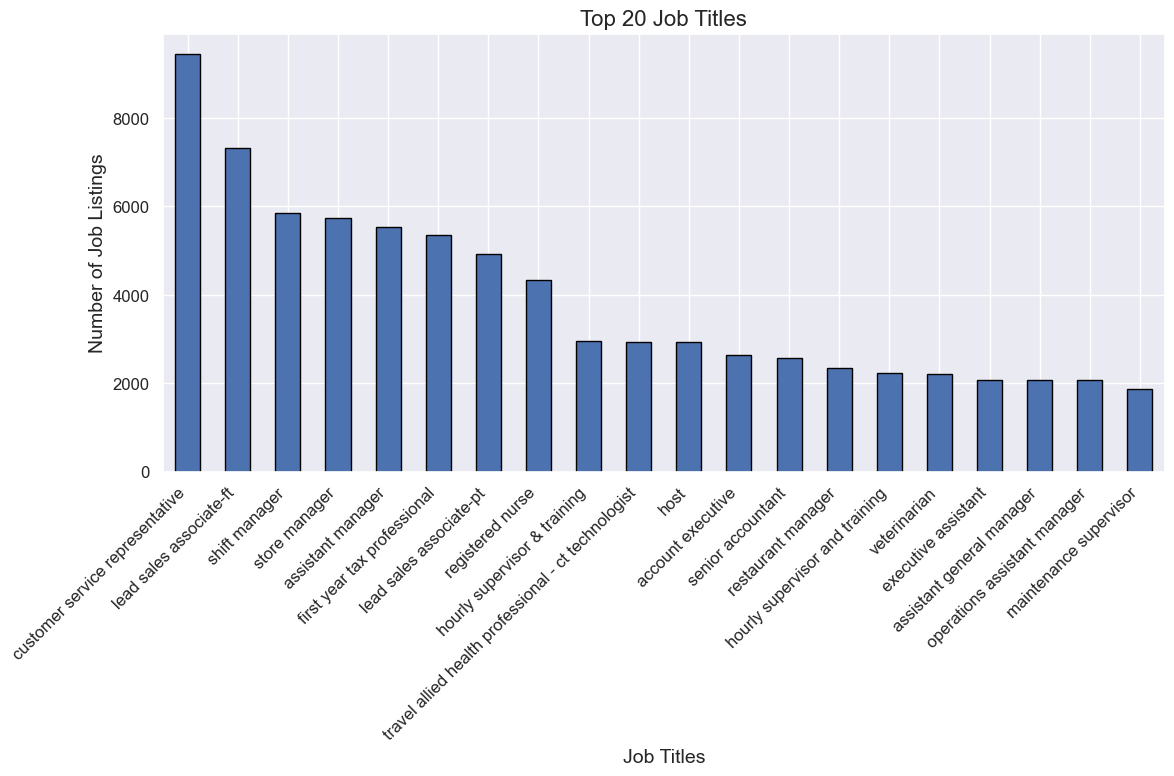

In [65]:
top_job_titles = job_postings['job_title'].str.lower().value_counts().head(20)

plt.figure(figsize=(12, 8))
top_job_titles.plot(kind='bar', edgecolor='black')
plt.title('Top 20 Job Titles', fontsize=16)
plt.xlabel('Job Titles', fontsize=14)
plt.ylabel('Number of Job Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

Looking at the top 20 job titles gives a further inside: using '&' vs. "and" leads to essentially the same job title being counted as two different ones.
Let's replace all '&' with "and" and see if we can get a more accurate count of the job titles.

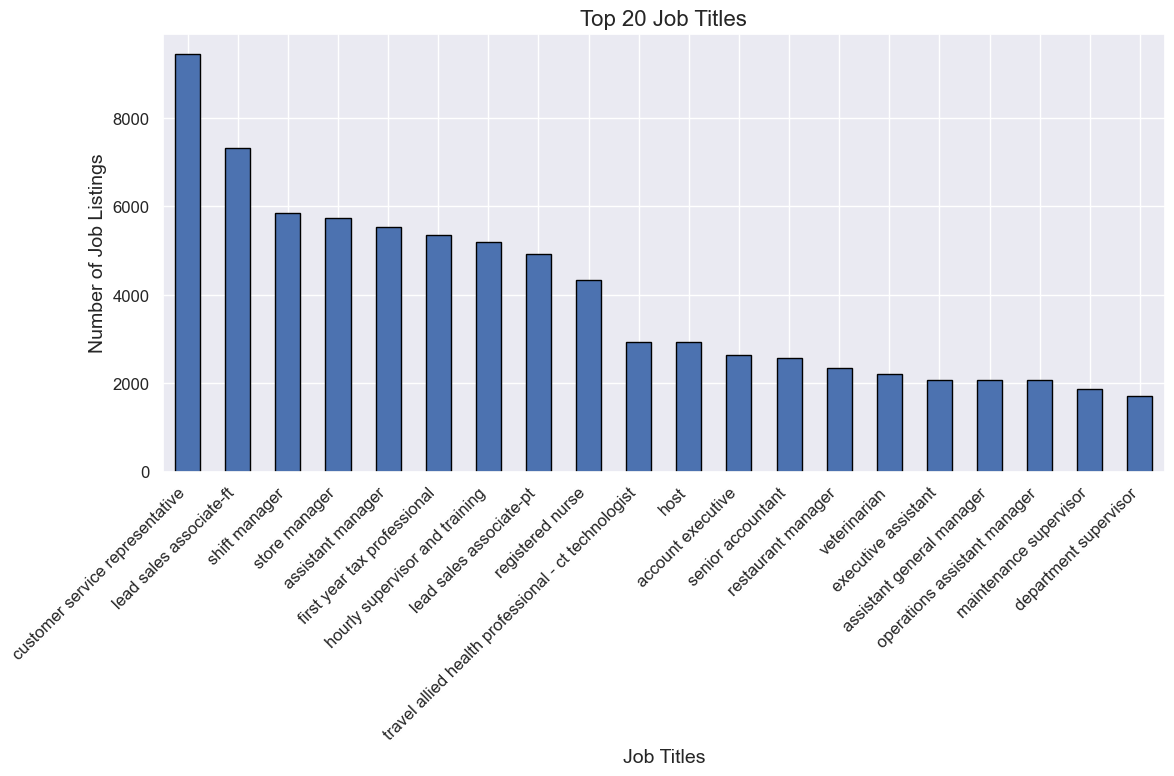

In [66]:
job_postings['job_title'] = job_postings['job_title'].str.replace('&', 'and')

top_job_titles = job_postings['job_title'].str.lower().value_counts().head(20)

plt.figure(figsize=(12, 8))
top_job_titles.plot(kind='bar', edgecolor='black')
plt.title('Top 20 Job Titles', fontsize=16)
plt.xlabel('Job Titles', fontsize=14)
plt.ylabel('Number of Job Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

That looks better now!
On we go then, with our exploration!

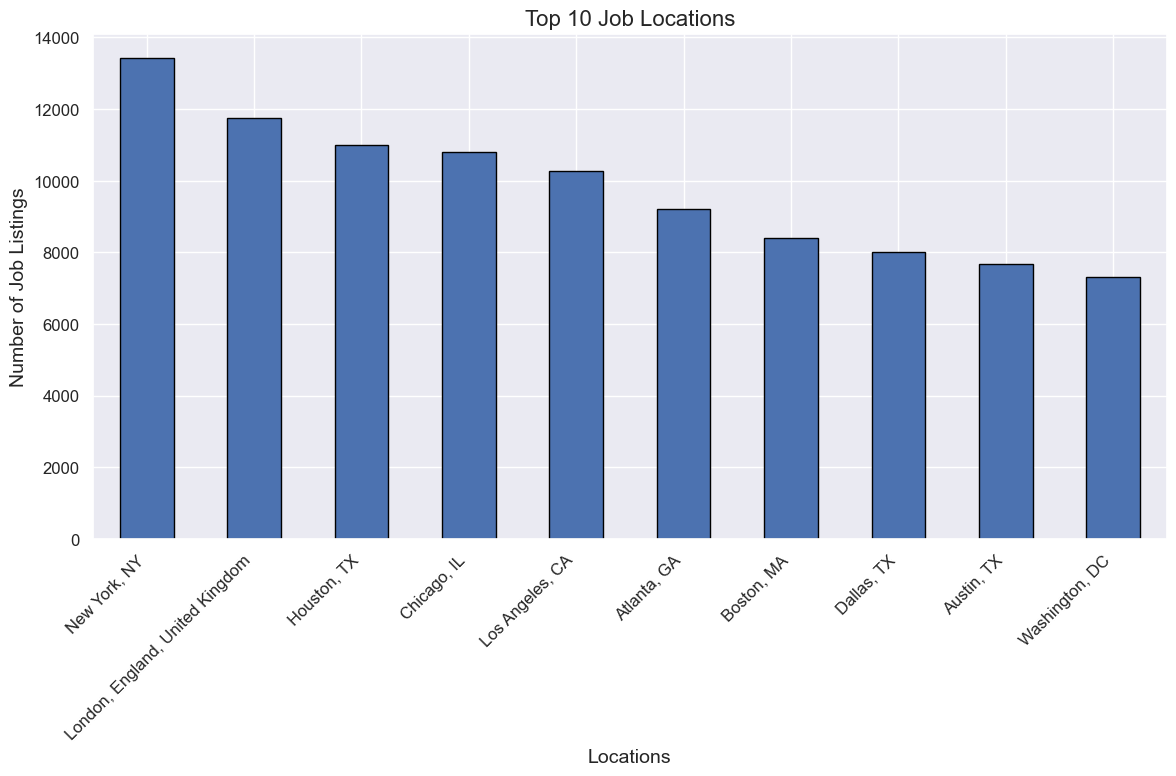

In [67]:
plt.figure(figsize=(12, 8))

top_locations = job_postings['job_location'].value_counts().head(10)
top_locations.plot(kind='bar', edgecolor='black')

plt.title('Top 10 Job Locations', fontsize=16)
plt.xlabel('Locations', fontsize=14)
plt.ylabel('Number of Job Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

Looks like all of our top 10 location - apart from London, UK, at second place - stem from the US. Personally, I would not have expected Houston, Texas, to have such a large job market.

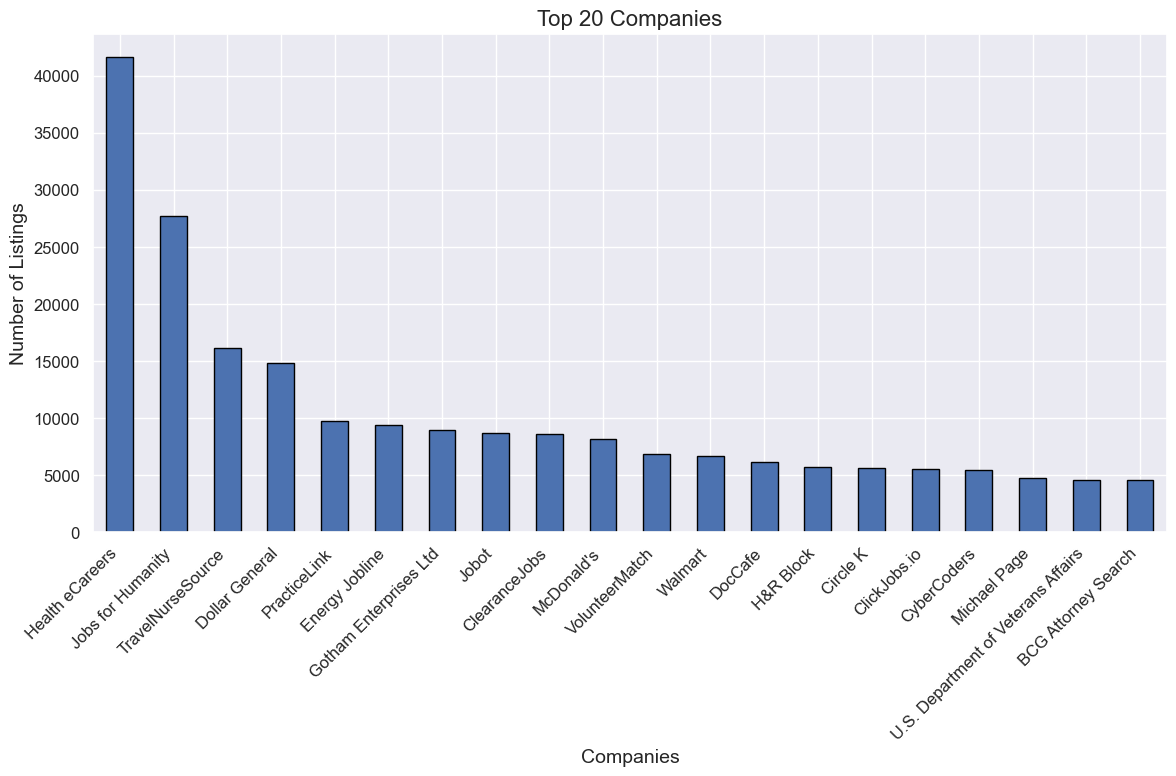

In [68]:
plt.figure(figsize=(12, 8))

top_locations = job_postings['company'].value_counts().head(20)
top_locations.plot(kind='bar', edgecolor='black')

plt.title('Top 20 Companies', fontsize=16)
plt.xlabel('Companies', fontsize=14)
plt.ylabel('Number of Listings', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

 Looks like a lot of open jobs are located in the healthcare sector (2 of the top 3 companies), with a high number of listings from companies that help other companies that connect job seekers with employers (e.g. Jobs for Humanity, CyberCoders).
 Instantly recognisable are McDonald's and Walmart, which are also in the top 20.

## Job Level Distribution
Let's see how the job levels are distributed.

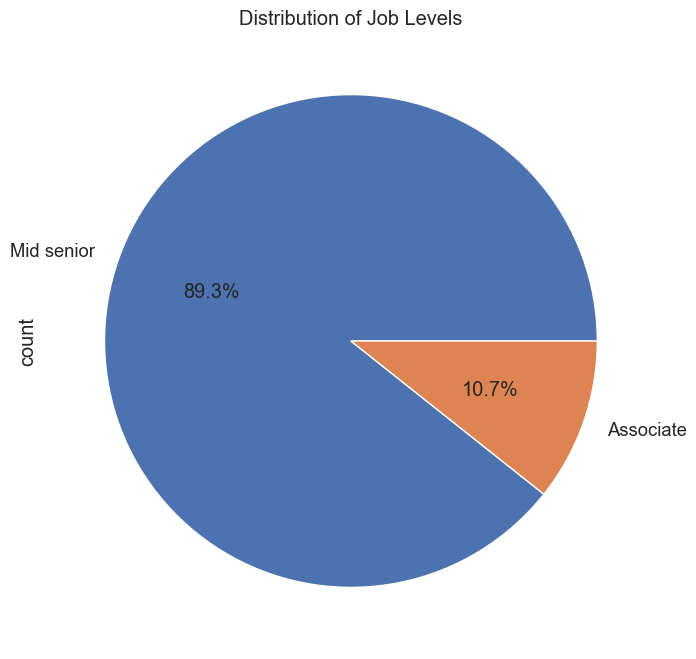

In [69]:
job_level_distribution = job_postings['job_level'].value_counts()
job_level_distribution.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Distribution of Job Levels')
plt.show()

Only "Mid senior" and "Associate" - that doesn't tell us much, so we might as well ignore/drop this column later.
I would have at least expected something along the lines of "Senior", "Junior" and "Mid" (or "Mid-level") to be in there, but I guess that's not the case for this dataset.

## How about "Job Types"?

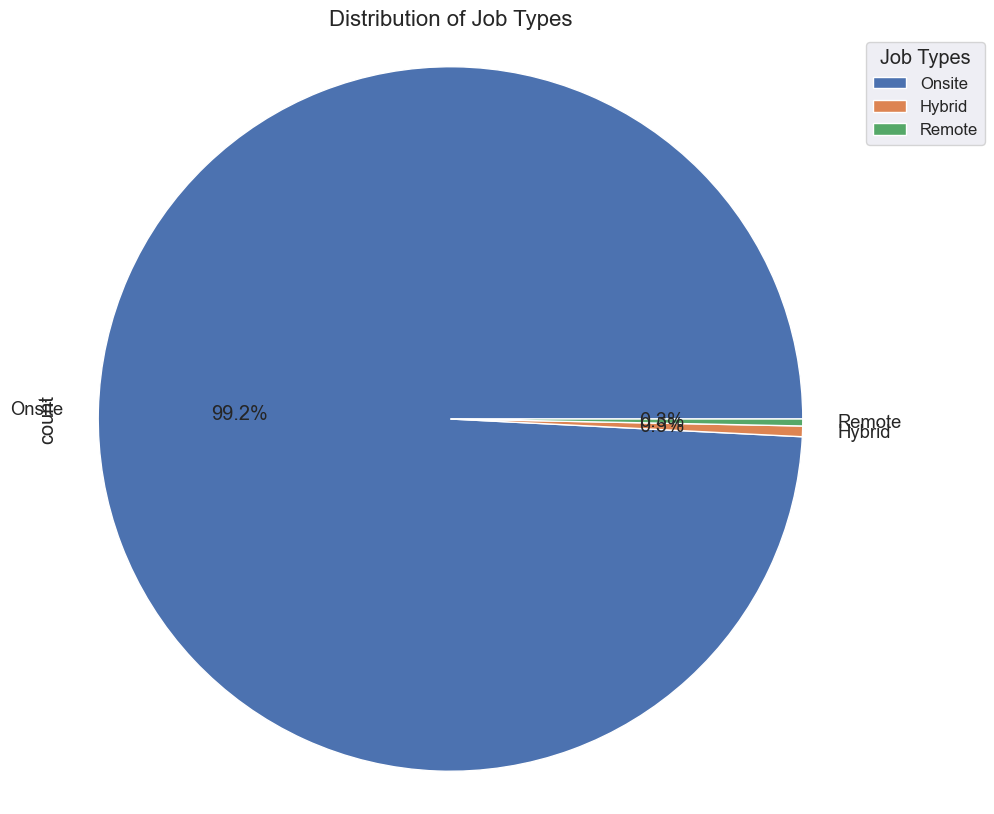

In [70]:
plt.figure(figsize=(10, 10))

job_type_distribution = job_postings['job_type'].value_counts()
job_type_distribution.plot(kind='pie', autopct='%1.1f%%')

plt.title('Distribution of Job Types', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(job_type_distribution.index, title='Job Types', loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=12)
plt.show()

Definitely more interesting; we'll keep this in case we want to do some analysis of remote/hybrid/onsite jobs for specific positions, etc.
Still, it's a bit surprising that Remote and Hybrid jobs together make up less than 1% of the job listings, given the current trend towards remote work.
But I guess that is party explained due to many job listings being for jobs in the healthcare sector or other high-job-count sectors, which are not really remote-work-friendly.

## Summary of Data Exploration
That concludes our initial data exploration. We have a good overview of the data we have to work with, and we can now proceed with the data preprocessing and then data analysis.
Unfortunately, something like a correlation analysis does not make sense, due to most of our data being text-based and mostly unique. The Pandas corr() function does not work with string data it can't convert.

# Data Preprocessing
Now let's drop some columns that we won't need for our analysis: last_processed_time, got_summary, got_ner, is_being_worked, first_seen and job_level.

In [71]:
job_postings = job_postings.drop(
    columns=['last_processed_time', 'got_summary', 'got_ner', 'is_being_worked', 'first_seen', 'job_level', 'search_position', 'search_city', 'search_country'])
job_postings.head()

job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/group-unit-...   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3                      Independent Real Estate Agent   
4  Group/Unit Supervisor (Systems Support Manager...   

                        company          job_location job_type  
0                            BD         San Diego, CA   Onsite  
1             Trinity Health MI     Norton Shores, MI   Onsite  
2       Wasatch Adaptive Sports             Sandy, UT   Onsite  
3    Howard Hanna | Rand Realty  Englewood Cliffs, NJ   Onsite  
4  IRS, Office of Chief Counsel          Chamblee, GA   Onsite

In [72]:
job_summaries.head()

job_link  \
0  https://www.linkedin.com/jobs/view/restaurant-...   
1  https://www.linkedin.com/jobs/view/med-surg-re...   
2  https://www.linkedin.com/jobs/view/registered-...   
3  https://uk.linkedin.com/jobs/view/commercial-a...   
4  https://www.linkedin.com/jobs/view/store-manag...   

                                         job_summary  
0  Rock N Roll Sushi is hiring a Restaurant Manag...  
1  Schedule\n: PRN is required minimum 12 hours p...  
2  Description\nIntroduction\nAre you looking for...  
3  Commercial account executive\nSheffield\nFull ...  
4  Address:\nUSA-CT-Newington-44 Fenn Road\nStore...

Looking at some of the job summaries, it seems like we have some newlines in there that we should remove.
When we use the text in our vectorisation later, we also don't really care about words like "and", "to", "for", "the", "a", "of", so we'll remove those as well, as they will otherwise just add noise to our analysis.

In [73]:
import re

# replacing all of these with a space, so that we don't end up with words that are stuck together
# we also don't want to replace stuff like 'a' without a space surrounding it, so we'll just replace all of them with a space on either side, thereby making sure we only take actual words
replacement_dict = {
    '\n': ' ',
    ' and ': ' ',
    ' to ': ' ',
    ' for ': ' ',
    ' the ': ' ',
    ' a ': ' ',
    ' of ': ' ',
    ' in ': ' ',
    ' with ': ' ',
    ' on ': ' ',
    ' at ': ' ',
    ' by ': ' ',
    ' as ': ' ',
    ' from ': ' ',
    ' or ': ' ',
    ' an ': ' ',
    ' is ': ' ',
    ' are ': ' ',
    ' that ': ' ',
    ' be ': ' ',
    ' will ': ' ',
    ' you ': ' ',
}

pattern = re.compile('|'.join(re.escape(key) for key in replacement_dict.keys()))

def replace_text(text):
    return pattern.sub(lambda match: replacement_dict[match.group(0)], text)

job_summaries['job_summary'] = job_summaries['job_summary'].apply(replace_text)

In [74]:
job_summaries.head()

job_link  \
0  https://www.linkedin.com/jobs/view/restaurant-...   
1  https://www.linkedin.com/jobs/view/med-surg-re...   
2  https://www.linkedin.com/jobs/view/registered-...   
3  https://uk.linkedin.com/jobs/view/commercial-a...   
4  https://www.linkedin.com/jobs/view/store-manag...   

                                         job_summary  
0  Rock N Roll Sushi hiring Restaurant Manager! A...  
1  Schedule : PRN required minimum 12 hours per p...  
2  Description Introduction Are looking a place d...  
3  Commercial account executive Sheffield Full ti...  
4  Address: USA-CT-Newington-44 Fenn Road Store C...

That looks much better now; let's go on to the job skills.

In [75]:
job_skills.head()

job_link  \
0  https://www.linkedin.com/jobs/view/housekeeper...   
1  https://www.linkedin.com/jobs/view/assistant-g...   
2  https://www.linkedin.com/jobs/view/school-base...   
3  https://www.linkedin.com/jobs/view/electrical-...   
4  https://www.linkedin.com/jobs/view/electrical-...   

                                          job_skills  
0  Building Custodial Services, Cleaning, Janitor...  
1  Customer service, Restaurant management, Food ...  
2  Applied Behavior Analysis (ABA), Data analysis...  
3  Electrical Engineering, Project Controls, Sche...  
4  Electrical Assembly, Point to point wiring, St...

The job skills are one single string of comma-separated skills, which is actually fine for our later analysis. Otherwise we could have split them into a list of skills instead.
They look good otherwise. The comma separation is important to keep because many skills include several words (e.g. "Project Controls").

Alright, now that we've cleaned it up a little, let's merge those three datasets into one, based on the job_link as the primary key.

In [76]:
data = pd.merge(job_postings, job_summaries, on='job_link')
data = pd.merge(data, job_skills, on='job_link')
data.head()

job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/registered-...   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3                      Independent Real Estate Agent   
4                              Registered Nurse (RN)   

                      company          job_location job_type  \
0                          BD         San Diego, CA   Onsite   
1           Trinity Health MI     Norton Shores, MI   Onsite   
2     Wasatch Adaptive Sports             Sandy, UT   Onsite   
3  Howard Hanna | Rand Realty  Englewood Cliffs, NJ   Onsite   
4           Trinity Health MI          Muskegon, MI   Onsite   

                                         job_summary  \
0  Responsibilities Job Description Summary Job D...   
1  Employment Type: Full time Shift: Description:...   
2  Job Details Description What You'll Do As Food...   
3  Who We Are Rand Realty a family-owned brokerag...   
4  Employment Type: Full time Shift: 12 Hour Nigh...   

                                          job_skills  
0  Medical equipment sales, Key competitors, Term...  
1  Nursing, Bachelor of Science in Nursing, Maste...  
2  Restaurant Operations Management, Inventory Ma...  
3  Real Estate, Customer Service, Sales, Negotiat...  
4  Nursing, BSN, Medical License, Virtual RN, Nur...

## Data Preprocessing Summary
We've optimised our data a bit by removing some columns we don't need, and cleaning up the job summaries.
Most of our data was already in a good state to begin with, so we didn't have to do much.
Let's proceed with the analysis.

## Data Analysis
Let's start by analysing the job summaries with a bag of words approach.
For this we have to first vectorise the job summaries, and then calculate the distance between the vectorised summaries.
To vectorise our texts we use the TextVectorisation layer from Keras, which will convert our text into a list of numbers based on the vocabulary it has learned from the texts.
In the code below we build our vectorisation model/vocabulary using the first 5000 job summaries.

In [77]:
from keras.layers import TextVectorization

vectorise_layer_summaries = TextVectorization()
vectorise_layer_summaries.adapt(data.job_summary[0:5000])
model = tf.keras.models.Sequential()

# This model only transforms strings into representations as a list of numbers based on the TextVectorization vocabulary we adapted above
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorise_layer_summaries)

Now that we have our model, we can use it to "predict" the vectorised form of the job summaries.
We'll do that for the first 50 job summaries, and then build bags of words by counting the occurrences of each word in the vocabulary for each summary and saving that together with the vocabulary word-index.

In [78]:
number_of_samples = 50
samples = data.job_summary[0:number_of_samples]

predictions = []
for i in range(0, number_of_samples):
    predictions.append(model.predict([data.job_summary[i]]))

vectorised_summaries = []

# convert all "predictions" (summary text as vocabulary indices) to vectorised form of those values, based on the vocabulary
# we end up with a vector of length vocabulary_size for each summary, with the count of each word in the summary as the value at the index of the word in the vocabulary
for i in range(0, number_of_samples):
    unique, counts = np.unique(predictions[i], return_counts=True)
    bla = dict(zip(unique, counts))
    array = np.zeros(vectorise_layer_summaries.vocabulary_size())
    for (index, value) in bla.items():
        array[index] = value

    vectorised_summaries.append(array)

vectorised_summaries = pd.DataFrame(vectorised_summaries)

1/1 [==============================] - 0s 22ms/step


Great! Now that we have that, we can calculate the distance between the vectorised summaries.

In [79]:
indices = range(0, 50)

summary_distances = np.zeros((number_of_samples, number_of_samples))

for i in indices:
    for j in indices:
        distance = np.linalg.norm(vectorised_summaries.iloc[i] - vectorised_summaries.iloc[j])
        summary_distances[i][j] = distance


Aaaaaaaand we have our distances!
Let's visualise them with a heatmap, so we can easily spot which job postings are most similar to each other.

<Axes: >

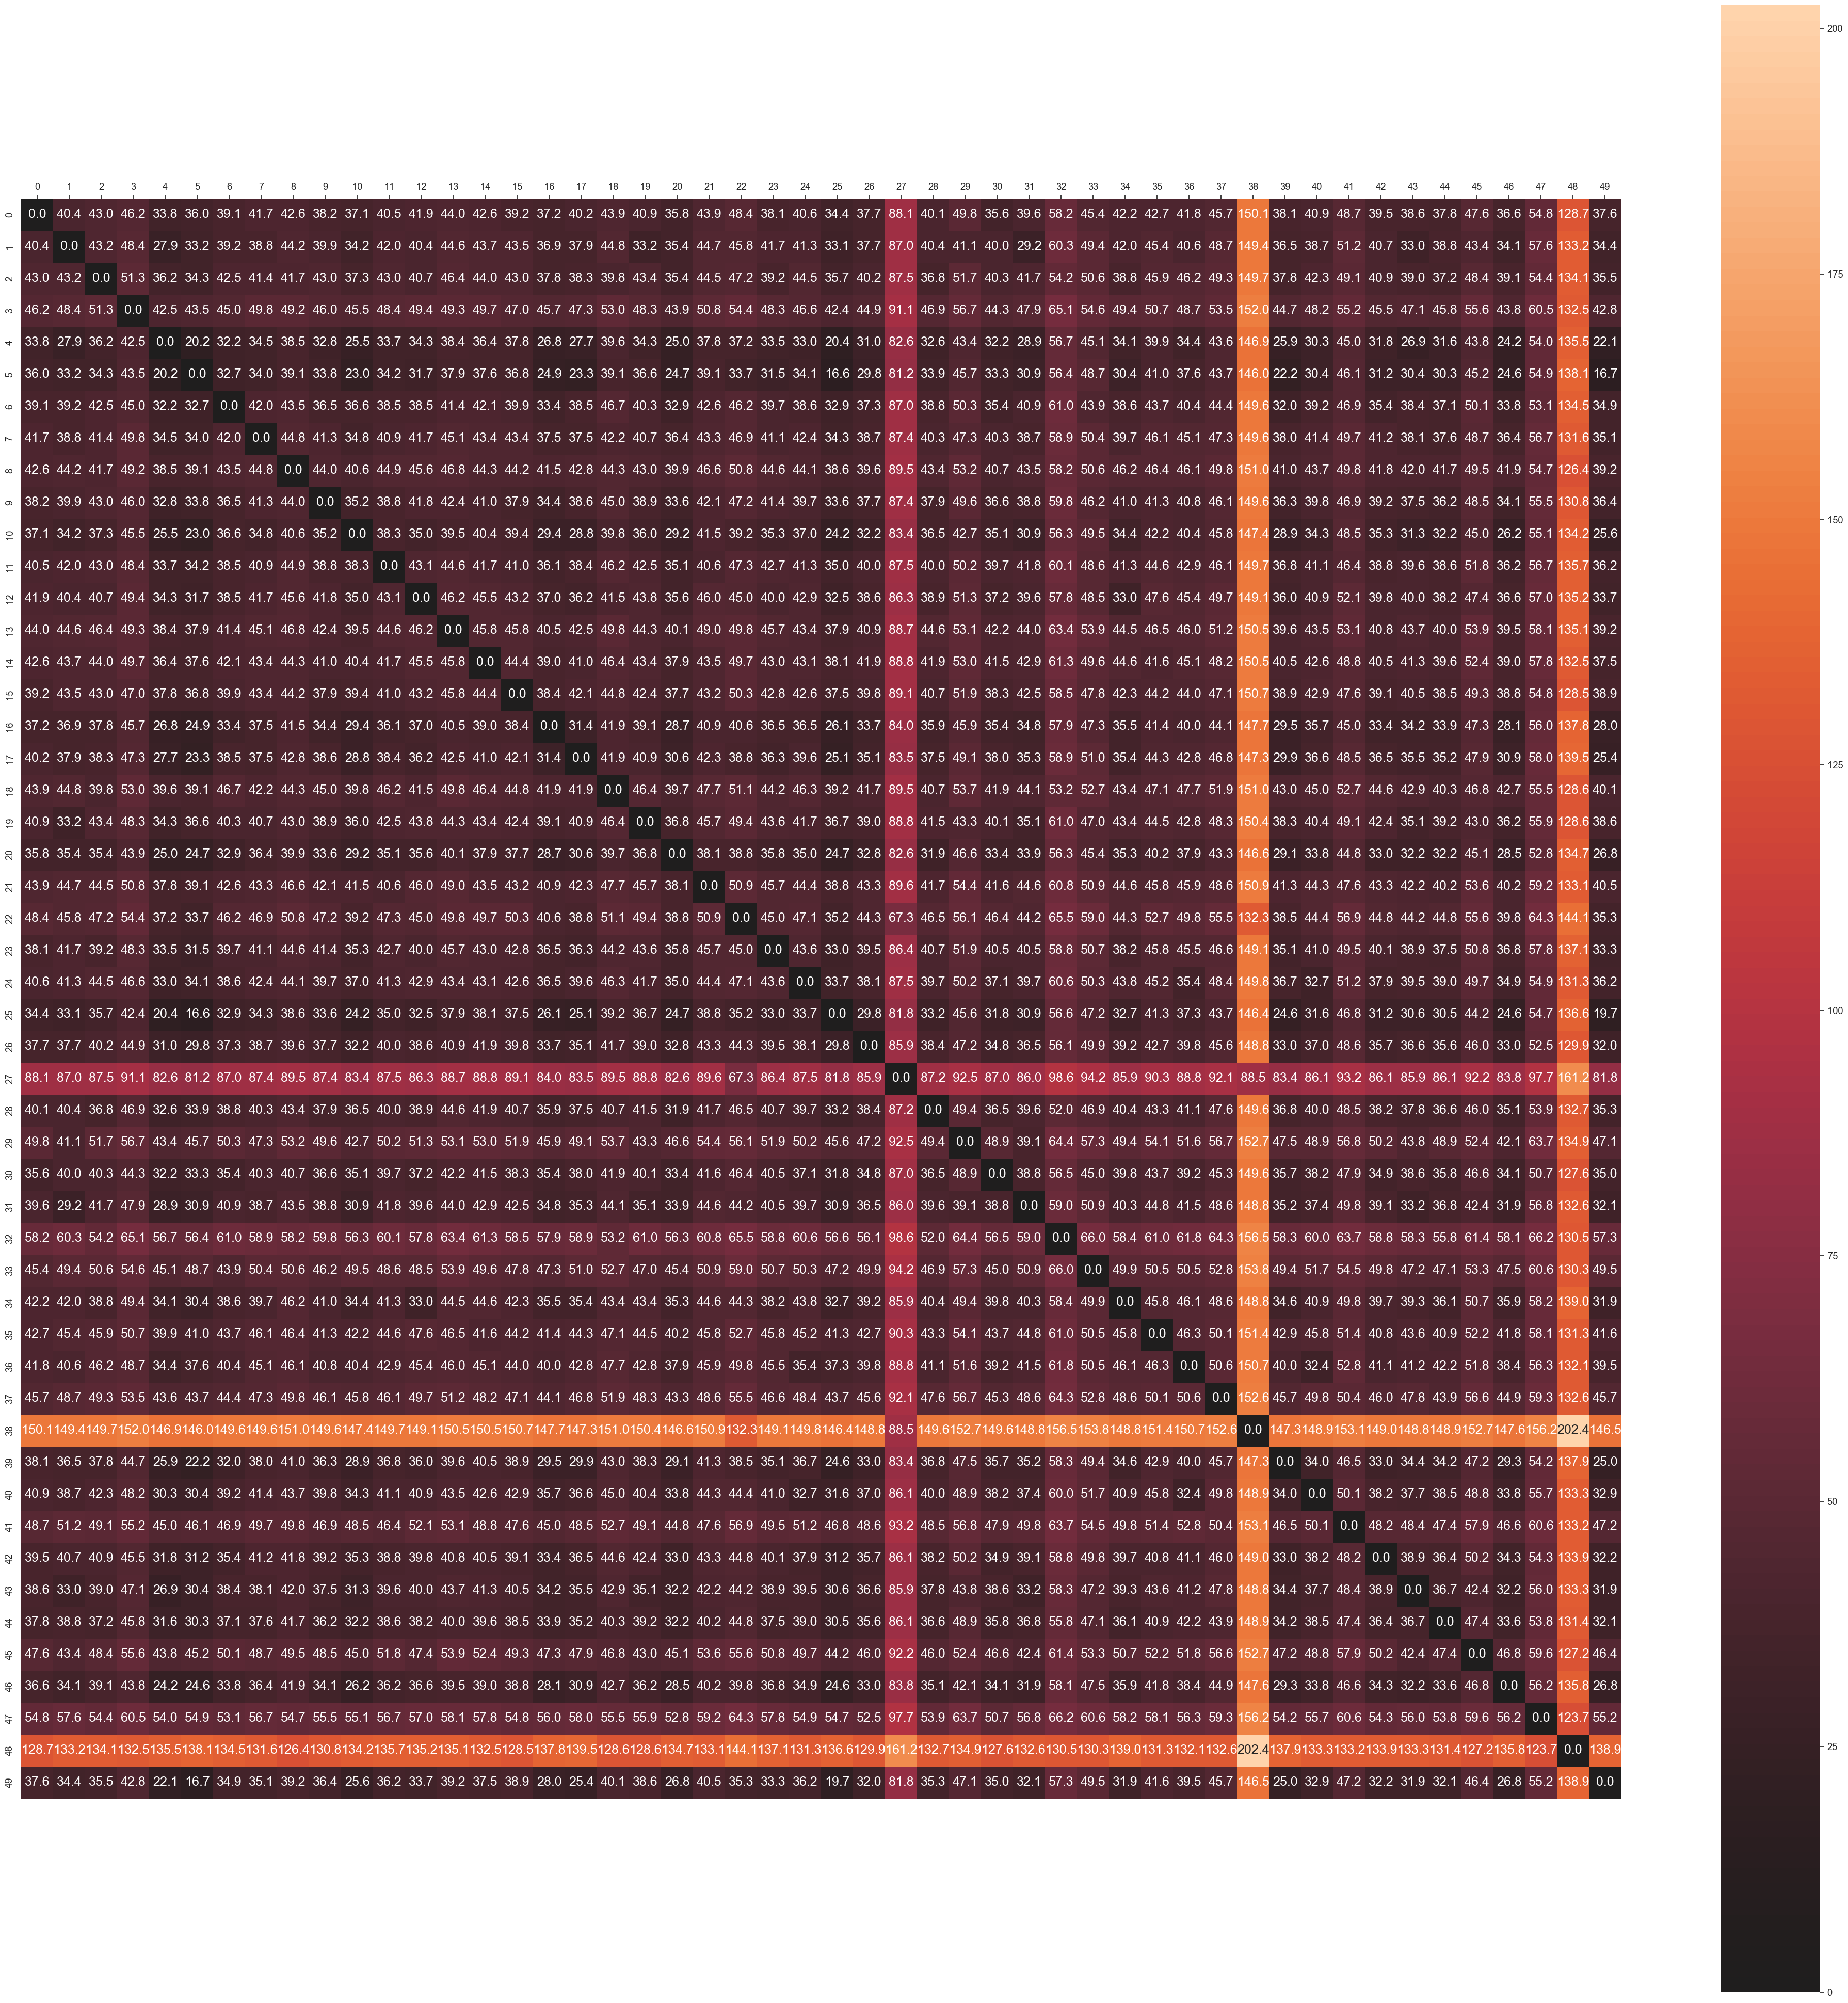

In [80]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.xaxis.tick_top()
sns.set(font_scale=1.2)
sns.heatmap(summary_distances, annot=True, square=True, ax=ax, fmt=".1f", center=0.0, annot_kws={"size": 18})

That looks great!
The diagonals are all 0, as they should be, and we can see that some job postings are more similar to each other than others.
We have a few outliers, such as indices 38 and 48.
With the two test cell below we can simply check two job postings against each other.

In [81]:
# Test cell for easy experimentation
i = 5
j = 4
print(data.job_title[i], " vs. ", data.job_title[j])

print(summary_distances[i][j])

Part Time- HR Generalist  vs.  Registered Nurse (RN)
20.199009876724155


In [82]:
print(data.job_summary[i])
print(data.iloc[i])
print("__________________________________________________________________________________")
print(data.job_summary[j])
print(data.iloc[j])
print("__________________________________________________________________________________")

Title About The Company A leading consulting firm, who has been around over 30 years! They partner foundations, nonprofits, companies propel positive social change through strategy, capacity building, initiative design, strategic communication, management. Located West Midtown, 24-28 hours per week. Close knit team, corporate yet relaxed environment excellent training provided! Overview Of The Role Performance reviews Setting up interviews recruitment HR onboarding Managing employee complaints / employee relations Following up reviews new hires (90 day) Qualifications Non-profit experience a plus! 3+ years HR experience a plus! #INJAN2024 #CBJAN2024 Show more Show less
job_link        https://www.linkedin.com/jobs/view/part-time-h...
job_title                                Part Time- HR Generalist
company                         Creative Financial Staffing (CFS)
job_location                                         New York, NY
job_type                                                  

Alright, now we can guess why those two jobs are so different (distance of 202).
Index 38 a canadian job, written in French - which of course leads to almost every single word being different from all the other job postings we have in our sample of 50.
Index 48 on the other hand is quite long (which contributes to the distance to other job postings), and it seems to include a bunch of very specific info, including "acceptable wartime service dates" and the like, which I would not have expected to be in a job summary (especially not when the "acceptable wartime service dates" include 1940 - how old are they expecting their applicants to potentially be??).

Playing around with the indices above some more, we can also quickly discover the reason why some jobs have a rather low distance, e.g. indices 4 & 5 ("Part Time- HR Generalist" and "Registered Nurse (RN)"), with a distance of 20.
The most likely reason is that both job summaries are quite short, leading to a lower distance, because our vectorised summaries are based on the count of each word in the summary, and with few words overall, our counts for those words will be lower, and we'll have fewer dimensions which are simply 0, because the word is not in the summary.
A definite weak point in this approach, but we'll have to live with it for now.
In the future we could segment the job summaries into smaller parts, and then calculate the distance between those parts, and then take the average of those distances as the distance between the two job postings.
Or alternatively group summaries/job postings into categories by the size of their summary, and then calculate the distance between summaries that have roughly the same length.

Let's also correlate the job skills, so we can calculate a total score of correlation between two job postings.
For this we will use the modified bag of words approach again, similar to our approach to correlating the job summaries (okay, literally the same).

In [83]:
# build the model/vocabulary using the first 250 job skills
vectorise_layer_skills = TextVectorization()
vectorise_layer_skills.adapt(data.job_skills[0:250])
skills_model = tf.keras.models.Sequential()

# This model only transforms strings into representations as a list of numbers based on the TextVectorization vocabulary we adapted above
skills_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
skills_model.add(vectorise_layer_skills)

In [84]:
number_of_samples = 50 # we only look 50 samples compared to each other, because we can't show more properly in one heatmap
samples = data.job_skills[0:number_of_samples]

predictions = []
for i in range(0, number_of_samples):
    predictions.append(skills_model.predict([data.job_skills[i]]))

vectorised_skills = []

# convert all "predictions" (summary text as vocabulary indices) to vectorised form of those values, based on the vocabulary, with the count of each word in the summary as the value at the index of the word in the vocabulary
for i in range(0, number_of_samples):
    unique, counts = np.unique(predictions[i], return_counts=True)
    bla = dict(zip(unique, counts))
    array = np.zeros(vectorise_layer_skills.vocabulary_size())
    for (index, value) in bla.items():
        array[index] = value

    vectorised_skills.append(array)

skills_df = pd.DataFrame(vectorised_skills)

1/1 [==============================] - 0s 23ms/step


In [85]:
indices = range(0, 50)

skills_distances = np.zeros((number_of_samples, number_of_samples))

# calculate the distance between the vectorised skills
for i in indices:
    for j in indices:
        distance = np.linalg.norm(skills_df.iloc[i] - skills_df.iloc[j])
        skills_distances[i][j] = distance

<Axes: >

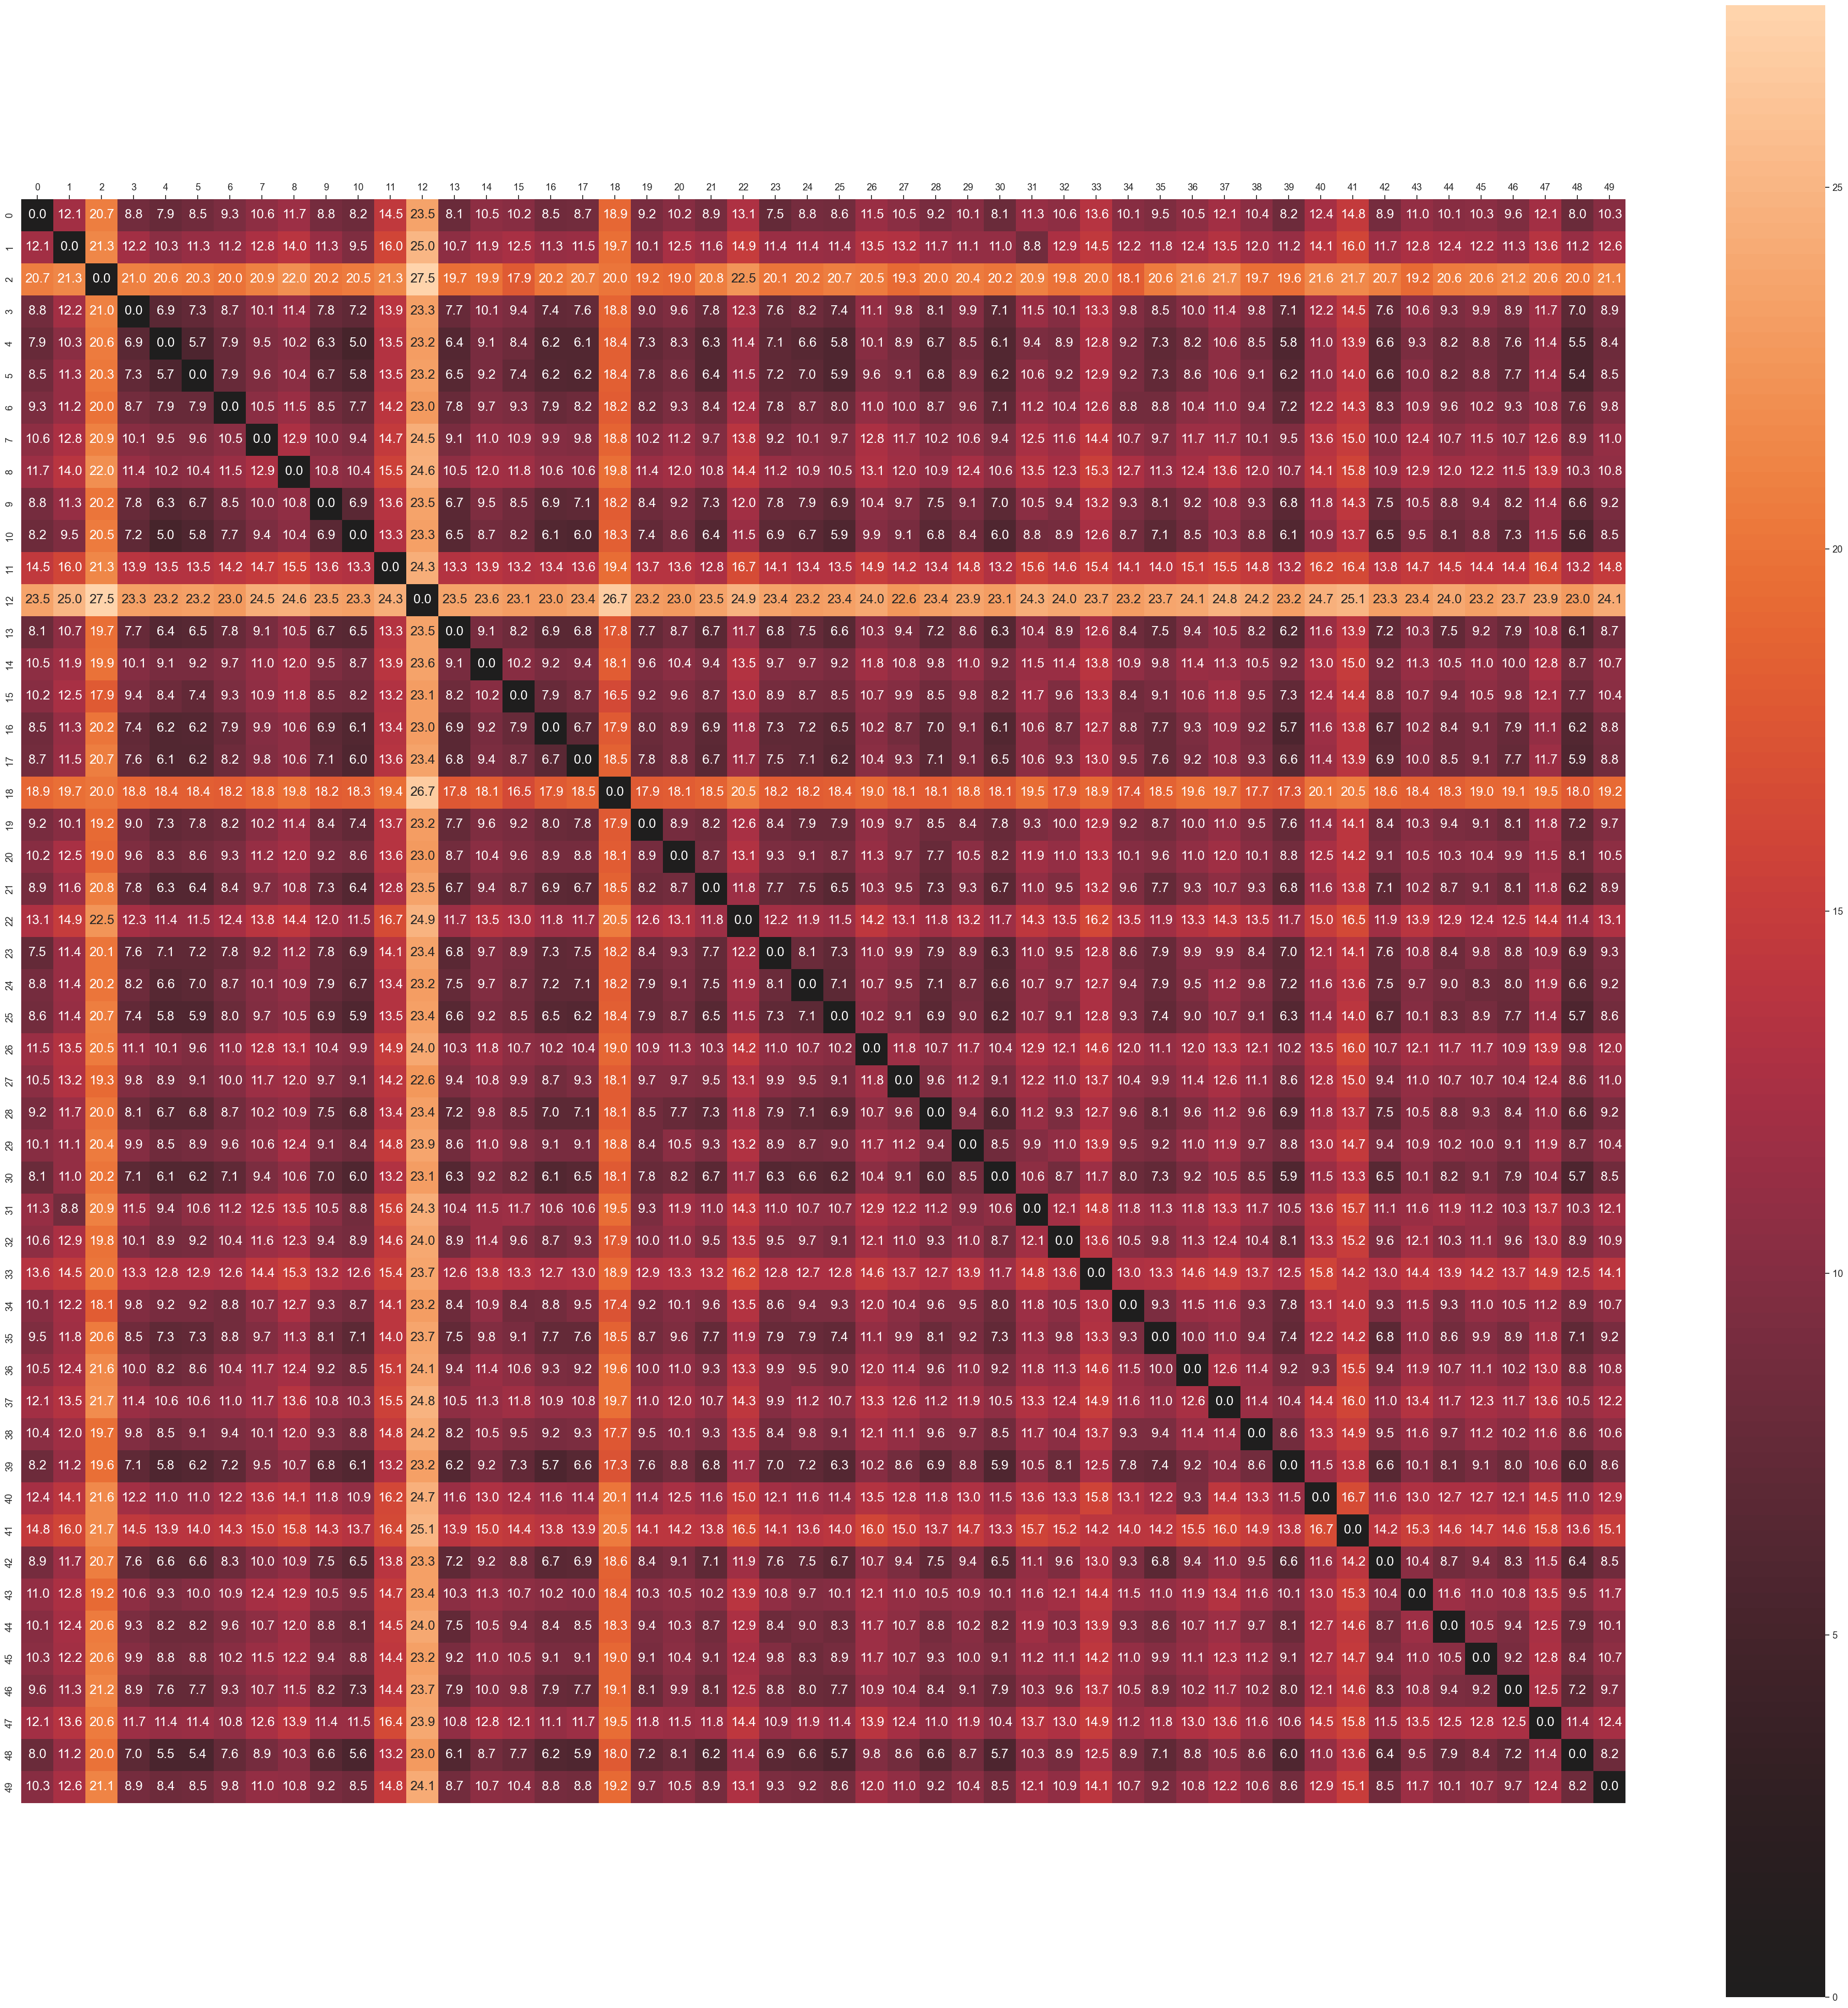

In [86]:
fig, ax = plt.subplots(figsize=(50, 50))
ax.xaxis.tick_top()
sns.set(font_scale=1.2)
sns.heatmap(skills_distances, annot=True, square=True, ax=ax, fmt=".1f", center=0.0, annot_kws={"size": 18})

That look markedly different. We can use the cells below for some experimentation.

In [87]:
# Test cell for easy experimentation
i = 7
j = 12
print(data.job_title[i], " vs. ", data.job_title[j])

print(skills_distances[i][j])

Engineering Project Coordinator  vs.  LEAD SALES ASSOCIATE-PT
24.454038521274967


In [88]:
print(data.job_skills[i])
print("__________________________________________________________________________________")
print(data.job_skills[j])

AUTOCAD, MS Project, Building Code Compliance, Construction methods, Sustainability design concepts, Barrierfree access, Environmental risks, Engineering, Project management, Construction management, Medical gases, Plumbing, Steam, HVAC, Building controls, Fire suppression, Power distribution, Nurse call, Access controls, Building envelope systems, Roofing, Glazing, Door systems, Business management, Business ethics, Negotiation, Planning, Organizing, Forecasting, Collaboration, Communication
__________________________________________________________________________________
Cashier, Stocker, Lead capacity, Planograms, Customer service, Unloading trucks, Receiving, Opening cartons, Unpacking cartons and totes, Stocking merchandise, Rotating merchandise, Facing merchandise, Building merchandise displays, Restock merchandise, Order zones, Drop shipment categories, Planogram implementation, Planogram maintenance, Customer assistance, Bailing cardboard, Taking out trash, Dusting and mopping

We again run into the problem that the distance is quite low for job postings with short skill lists, and quite high for job postings with long skill lists, because of the increased number of non-null dimensions.
This can, for example, be observed for the distances from index 12 to other skill lists.
Looking at these long skills lists, I can't help but question whether such a long skill list even makes sense for a job posting. First, who even reads that whole list, second, what kinds of "skills" are "Employee Handbook" and "Completing paperwork"? I would have expected those to be part of the job description, not the skills list.

### Let's combine our two distances into one, by simply adding them together.
I believe that this simple approach will work well enough for our purposes, as the two distances are based on the same principle, and we don't have any reason to believe that one of the two distances is more important than the other.
For good measure we'll also divide the combined distance by 2, so that we have a distance that is on the same scale as the individual distances.

<Axes: >

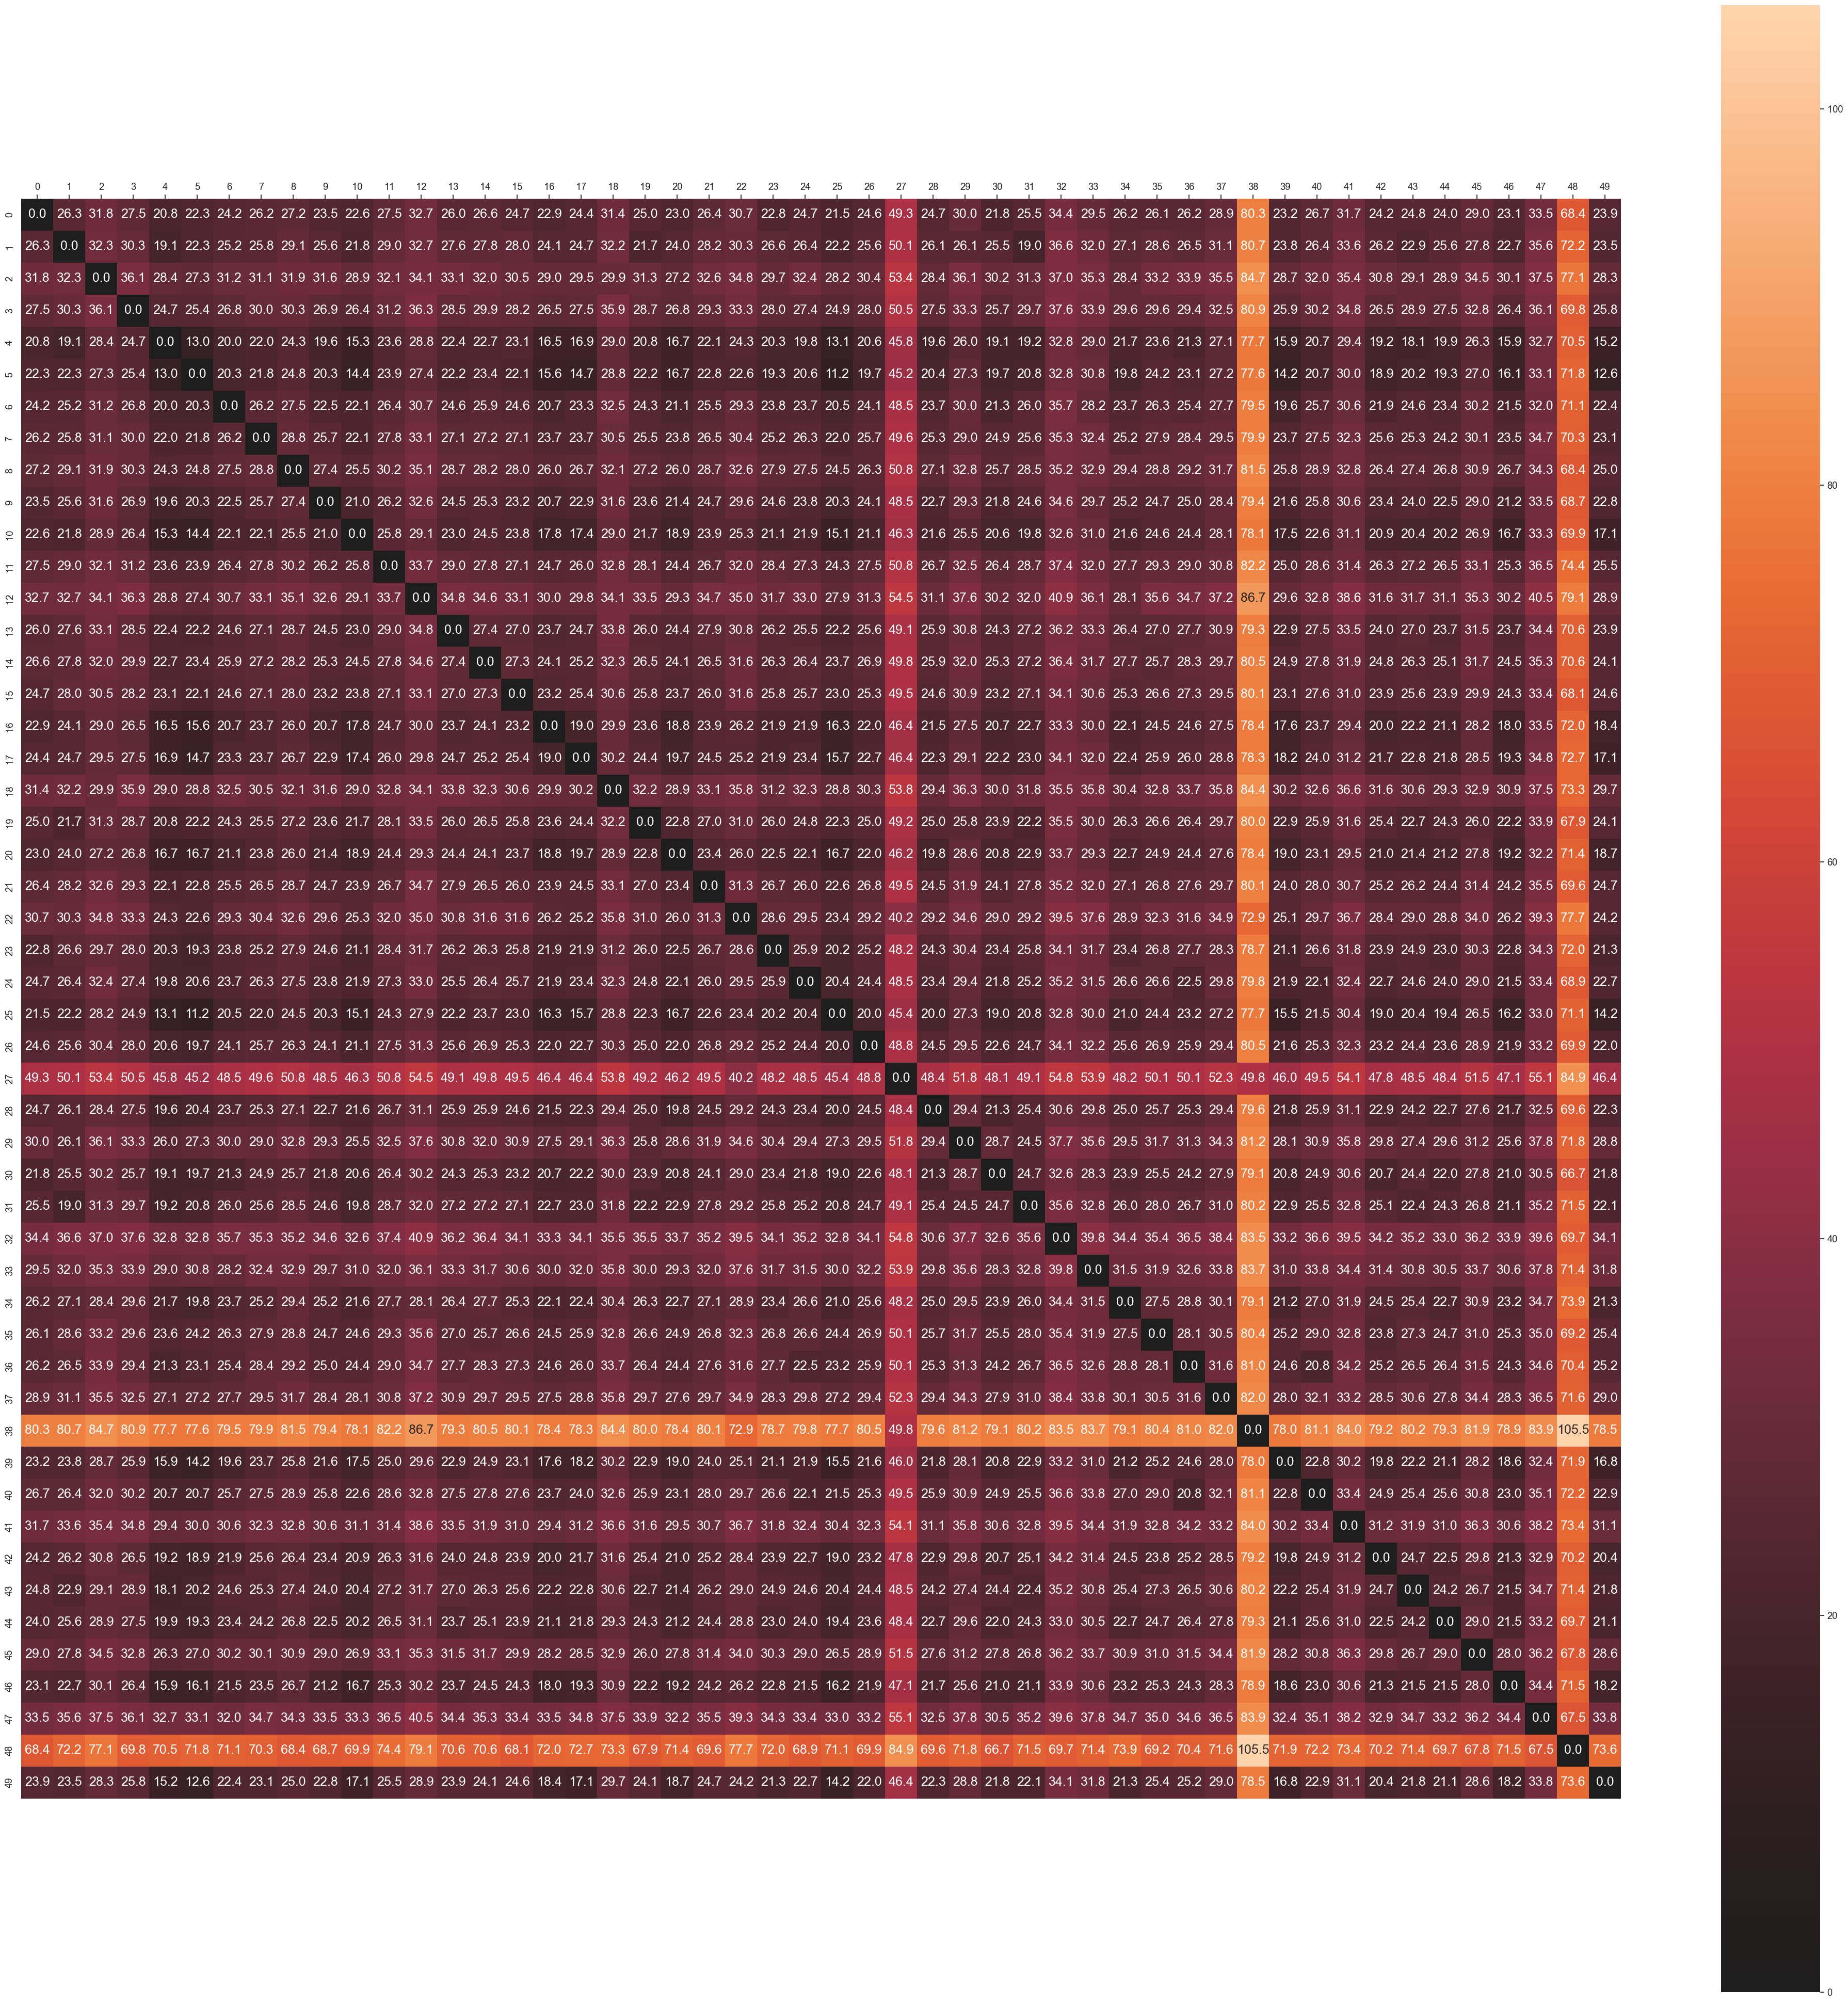

In [89]:
combined_distances = (summary_distances + skills_distances) / 2
fig, ax = plt.subplots(figsize=(50, 50))
ax.xaxis.tick_top()
sns.set(font_scale=1.2)
sns.heatmap(combined_distances, annot=True, square=True, ax=ax, fmt=".1f", center=0.0, annot_kws={"size": 18})

Alright, we have our combined distances, and we can now use this to find the most similar job postings to a given job posting.

In [90]:
def get_most_similar_jobs(job_index, n=5):
    distances = combined_distances[job_index]
    sorted_indices = np.argsort(distances)
    return sorted_indices[1:n+1]

def print_similar_jobs(job_index, n=5):
    similar_jobs = get_most_similar_jobs(job_index, n)
    print("Most similar jobs to ", data.job_title[job_index], " (index ", job_index, "):")
    for i in similar_jobs:
        print(data.job_title[i], " (index ", i, ")")
        

In [91]:
# Test cell for easy experimentation
job_index = 37
print_similar_jobs(job_index)

Most similar jobs to  Sr Experience Design Manager, Learn and Help  (index  37 ):
Registered Nurse (RN)  (index  4 )
Part Time- HR Generalist  (index  5 )
Property Manager  (index  25 )
Supervisor - Horticulturist  (index  16 )
Chef de Cuisine  (index  20 )


Playing around with the above a little, some similarities make sense, while others seem a bit off. (also: what the heck is a "Cheese Specialist"?)
I'll go over some shortcomings and improvements later, but let's just say for now that it kind of works, but as expected it is pretty rough.

We can observe that indices with a short job summary and/or skill list are "similar" to essentially every other job posting (because the distance is usually lower than jobs with longer summaries/skill lists). For example, indices 4 and 5 ("Registered Nurse (RN)" and "Part Time- HR Generalist") are similar to almost every other job posting, because they have short summaries and skill lists. Certainly not the kind of result we were hoping for.

## And Now for Something Completely Different (almost)
Given the shortcomings of the bag of words approach, we will now try a different approach to predicting the skills for a job posting based on its summary.
The usecase for this would be to enable hiring managers to generate the list of skills for their job postings from the summary they have already written for it.
We will use a Random Forest classifier as our model, and train it on a subset of the data (the size being limited by the machine I'm working with, see below), and then use it to predict the skill list for a different subset of the data.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV # technically not needed anymore, but I'll keep it in case I want to use it later
from sklearn.ensemble import RandomForestClassifier

With a training set length of 3000 samples, and a train/test split of 80%/20%, training the model takes about 20 minutes on my (16-core) machine.
3000 doesn't really feel like much, given that we have more than 1 million job postings, but I'm limited by my machine's memory and the time it takes to train the model.

We'll also split the skills into a list of skills, so that we can use the MultiLabelBinarizer to transform the skills into a binary matrix, which we can then use to train our model.

In [93]:
training_length = 3000

skills_train = data.job_skills[0:training_length].str.split(', ')
summary_train = data.job_summary[0:training_length]

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(skills_train)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(summary_train, y, test_size=0.2, random_state=42)

We will use a TfidfVectorizer to vectorise our text data, and then train a RandomForestClassifier on the vectorised data.
TFDIF = Term Frequency - Inverse Document Frequency, see https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/ for a good explanation.
This is an alternative to the Bag of Words approach used for our first model.

The parameters we are using for our RandomForestClassifier are pretty close to the default parameters, but we are using a max_depth of 30, because the default is None, and we don't want to overfit our model.

In [94]:
# Create a TfidfVectorizer; TFDIDF = Term Frequency - Inverse Document Frequency
tfidf = TfidfVectorizer(stop_words='english', max_features=250)

# Fit and transform the training data, and transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

rf = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=30, min_samples_split=2, min_samples_leaf=1)
multi_target_dtree = MultiOutputClassifier(rf, n_jobs=-1)

## Optimising the model
I tried to run a grid search to find the best parameters for the model, but it took too long to run on my machine/kept running into memory errors, so I was unable to complete it; just assume this worked...
Code is still below.

In [95]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# 
# }
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# 
# # Fit it to the data
# grid_search.fit(X_train_tfidf, y_train)
# 
# # Best parameters found
# print(grid_search.best_params_)

## Training the model
Let's just fit the model with the original parameters.

In [96]:
# Fit the model on the vectorized text data
multi_target_dtree.fit(X_train_tfidf, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=30,
                                                       n_estimators=500,
                                                       random_state=42),
                      n_jobs=-1)

We have a model, yay!

## Results & Analysis
Let's generate some predictions with our X_test dataset and see how well our model performs.

In [97]:
# Predict skills lists for our vectorised summary test data
y_pred = multi_target_dtree.predict(X_test_tfidf)
predicted_skills = mlb.inverse_transform(y_pred)

In [98]:
print("Precision score: ", precision_score(y_test, y_pred, average='micro'))
print("Accuracy score: ", accuracy_score(y_test, y_pred))

non_empty_skills = [skills for skills in predicted_skills if skills != ()]

print("Number of non-empty skill-lists: ", len(non_empty_skills))
print("Percentage of non-empty skills: ", len(non_empty_skills) / len(predicted_skills))

Precision score:  0.41821561338289964
Accuracy score:  0.0
Number of non-empty skill-lists:  131
Percentage of non-empty skills:  0.21833333333333332


We have achieved a precision score of 0.42% and an accuracy score of 0%.
The 0% accuracy is probably because of the implementation of the accuracy score for multi-label classifiers: "In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must *exactly* match the corresponding set of labels in y_true." (from the documentation of the accuracy_score function).
The precision_score function on the other hand treats multiclass problems as a collection of binary problems, and calculates the precision for each, and then takes the average of those precisions.
So we for roughly 42% of skills we have predicted that they are in the skill list, they are actually in the skill list, but for no summaries did we predict the exact skill list.

Furthermore, it seems that most of the predicted skill lists are empty - only 21.8% of the predicted skill lists are non-empty.
That really isn't a great result, and it looks like the precision above is not really meaningful, as the model is not able to predict the skill lists for most of the job postings. It's probably only calculated for the non-empty skill lists, which is why it's so "high" (compared to the percentage of non-empty skill lists).

Let's take a look some of the non-empty predicted skill lists nonetheless to get a feeling for how they look.

In [99]:
# experimentation cell to easily compare two predicted skill lists.
i = 8
j = 9
print(predicted_skills[i])
print(predicted_skills[j])

('Accounting', 'Bank Deposits', 'Cost Controls', 'Human Resources', 'Inventory Management', 'Marketing', 'Microsoft Office Suite', 'Performance Appraisals', 'Safety Management', 'Sales Building', 'Training')
('CPA', 'Customer Service', 'EA', 'Tax Laws', 'Video Communication Software')


Those don't look too bad. Let's take a look at the actual skills in the test set.

In [176]:
print(mlb.inverse_transform(y_test)[i])
print(mlb.inverse_transform(y_test)[j])

('Accounting', 'Bank Deposits', 'Basic Computer Skills', 'Cost Controls', 'Human Resources', 'Inventory Management', 'Marketing', 'Performance Appraisals', 'Safe Work Environment', 'Sales Building', 'Training')
('CPA', 'Commercial tax preparation software', 'Customer service', 'Documentation', 'EA', 'Federal individual 1040 tax returns', 'Government websites', 'PTIN', 'Practicing Attorney', 'Professional resources', 'State individual 1040 tax returns', 'State of the art video communication software', 'Tax preparation', 'TurboTax Live', 'TurboTax products', 'Video communication')


The first one (index 8) matches the original skill list quite closely!
The second one (index 9) does not match the original skill; for some reason the predicted skill list is very short compared to the original one. But at least the skills that ARE predicted match the original skill list well. The model even "improvised" a bit, predicting skills which are not in the original skill list, but which are related to the skills in the original skill list: 'Video Communication Software' and 'Tax Laws' are not mentioned as individual skills but fit in with the original list, the former even part of one of the skills ('State of the art video communication software') in the original list.

It seems that WHEN the model manages to predict a skill list, it does so quite well. The problem is that it only manages to predict a skill list in 21.8% of cases.

Overall, model performance is not great, with a precision of 0.418 and only 21.8% of predicted skill-lists not empty.
One reason for this is probably that we are only using 3000 samples for training and testing (with an 80/20 split).
With more samples I am limited by my machine's memory (the program will crash during model fitting), and time-limited by the time it takes to train the model & experiment with different parameters. With the current amount of samples and given hyperparameters, the training time was ca. 20 minutes.

Let's take a look at the training data - maybe the problem is that we have a lot of empty skill lists in the training data?

In [165]:
non_empty_skills_train = [skills for skills in skills_train if skills != ()]
print("Number of non-empty skill-lists: ", len(non_empty_skills_train))

Number of non-empty skill-lists:  3000


It does not seem to be a problem with our training data, as we don't have any empty skill lists in the training data.
So the problem is a mystery for now - one that would definitely need to be investigated further as part of the next steps.

## Discussion and Conclusion

### Learning & Takeaways
This project was a great learning experience for me, as I got to work with a large dataset and experiment with different approaches to text analysis and classification.
One takeaway for this project is that working with large amounts of data can be quite challenging due to the amount of compute resources one needs - as can be gleaned from my two approaches, I ended up using only a very small fraction of the data, because my PC was not able to handle more.
Another takeaway is that the Bag of Words approach is not very effective for this kind of problem, as it does not take into account the meaning of the words, only their frequency. This problem occurs again (though not as fatally) in my second approach using a Random Forest classifier, as the model is not able to take into account the meaning of the words.
I also learned that there are many non-trivial errors that occur when working with data, and which are especially disheartening when having to wait for a result ends in some kind of error, stifling progress (at one point the grid search for parameters for the Decision Tree model was running for about 12 hours before running into a memory error...).

### Limitations
The main limitation of this project was the amount of data I was able to use, as well as the time it took to train the model. I would have liked to experiment with different hyperparameters and more samples, but I was limited by my machine's memory and the time it took to train the model.
As a result, the model's performance is not great, and I would definitely ot recommend using it in a real-world scenario - in fact it's essentially useless in 79% of cases, as it predicts an empty skill list.
The correlation analysis was much more fruitful, but it was limited by both the data, and the capabilities of the Bag of Words approach. In an ideal world, I would have liked to experiment with more advanced NLP techniques, such as word embeddings, to see if I could get better results. I believe the results would have been much better if I had had vectorised words for which the distance of their vectors correlated to their similarity (e.g. "Child" and "Parent" would be closer to each other than "Child" and "Programming"). Unfortunately I realised mid-way through some experiments on that front that I would not be able to get something even close to reasonable performance up and running within the scope of this project and the capabilities of my machine.

### Next Steps & Possible Improvements
The following improvements and next steps could be taken to improve the model and the analysis:
- Use cloud computing/a more powerful machine to train the model with more samples and experiment with different hyperparameters
- Experiment with more advanced NLP techniques, such as word embeddings, for the Bag of Words approach
- Use a different approach to the skills classification problem, such as a neural network - also use a different machine for this (e.g. cloud computing)
- A must-do next step would also be to investigate why the model is predicting so many empty skill lists, and to fix this issue (was it just because of suboptimal hyperparameters or little data used, or is there a deeper issue with the model?)

### Conclusion
As a conclusion, I would say that this project was a success in terms of learning, while not really a success in producing result that can be re-used in a real-world scenario. Solving non-trivial problems with machine learning is much harder than it can seem from the outside. 